In [52]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import echopype as ep
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import feature


In [53]:
fname = 'F:GLIDER2018/Echosounder/Echosounder/nc_files/GLIDER_SB_2018_v5-Phase0-D20180621-T080104-0.nc'
ed = ep.open_converted(fname)
ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')
ds

<string>:6: DeprecationWarning: `np.alen` is deprecated, use `len` instead


<xarray.Dataset>
Dimensions:                (frequency: 1, ping_time: 173, range_bin: 25296)
Coordinates:
  * ping_time              (ping_time) datetime64[ns] 2018-06-21T08:01:06.055...
  * frequency              (frequency) float64 3.33e+05
  * range_bin              (range_bin) int32 0 1 2 3 ... 25292 25293 25294 25295
Data variables:
    Sv                     (frequency, ping_time, range_bin) float64 nan ... ...
    range                  (frequency, ping_time, range_bin) float64 0.0 ... ...
    temperature            (ping_time) float64 8.0 nan nan nan ... nan nan nan
    salinity               (ping_time) float64 35.0 nan nan nan ... nan nan nan
    pressure               (ping_time) float64 5.0 nan nan nan ... nan nan nan
    sound_speed            (ping_time) float64 1.482e+03 nan nan ... nan nan nan
    sound_absorption       (ping_time, frequency) float64 0.08015 nan ... nan
    sa_correction          (frequency) float64 ...
    gain_correction        (frequency) float64 24.0
    equivalent_beam_angle  (frequency) float64 ...

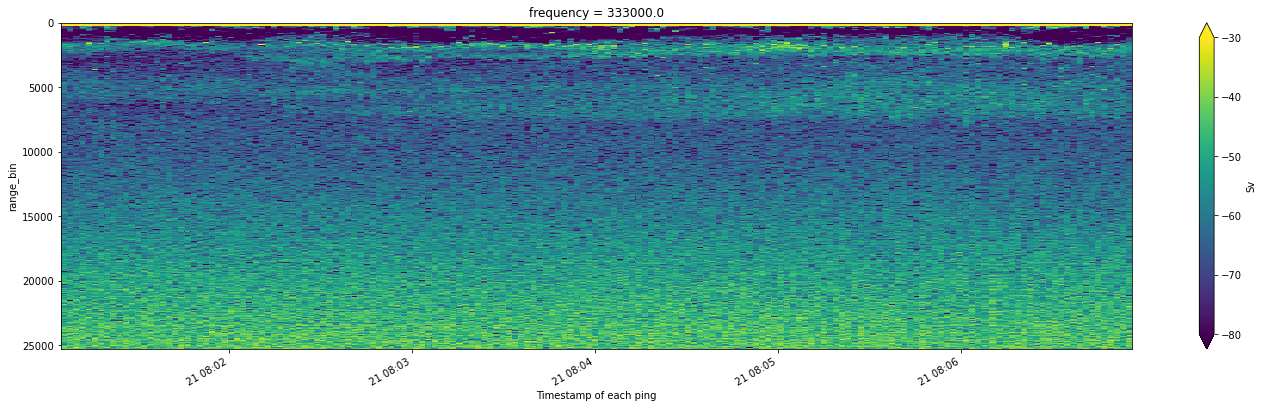

In [54]:
fig = (ds.Sv).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
fig.figure.patch.set_facecolor('white')
plt.gca().invert_yaxis()

# remove near-field
When the echosounder emits a ping, it takes some time for the ping to be fully formed and linear. To avoid non-linear effects, we remove the near-field before any processing.

In [55]:
nearfield = 3 #m from transducer face
maxSNR = 50.5 #m signal-to-noise ratio maximum

ds = ds.where((ds.range>nearfield) & (ds.range<maxSNR),drop=True)
ds = ds.isel(frequency=0) # remove frequency dimension
ds

<xarray.Dataset>
Dimensions:                (ping_time: 173, range_bin: 8011)
Coordinates:
  * ping_time              (ping_time) datetime64[ns] 2018-06-21T08:01:06.055...
    frequency              float64 3.33e+05
  * range_bin              (range_bin) int32 634 635 636 637 ... 8642 8643 8644
Data variables:
    Sv                     (ping_time, range_bin) float64 -85.67 ... -59.96
    range                  (ping_time, range_bin) float64 3.001 3.007 ... 50.5
    temperature            (ping_time, range_bin) float64 8.0 8.0 ... nan nan
    salinity               (ping_time, range_bin) float64 35.0 35.0 ... nan nan
    pressure               (ping_time, range_bin) float64 5.0 5.0 ... nan nan
    sound_speed            (ping_time, range_bin) float64 1.482e+03 ... nan
    sound_absorption       (ping_time, range_bin) float64 0.08015 ... nan
    sa_correction          (ping_time, range_bin) float64 0.0 0.0 ... 0.0 0.0
    gain_correction        (ping_time, range_bin) float64 24.0 24.0 ... 24.0
    equivalent_beam_angle  (ping_time, range_bin) float64 -21.0 -21.0 ... -21.0

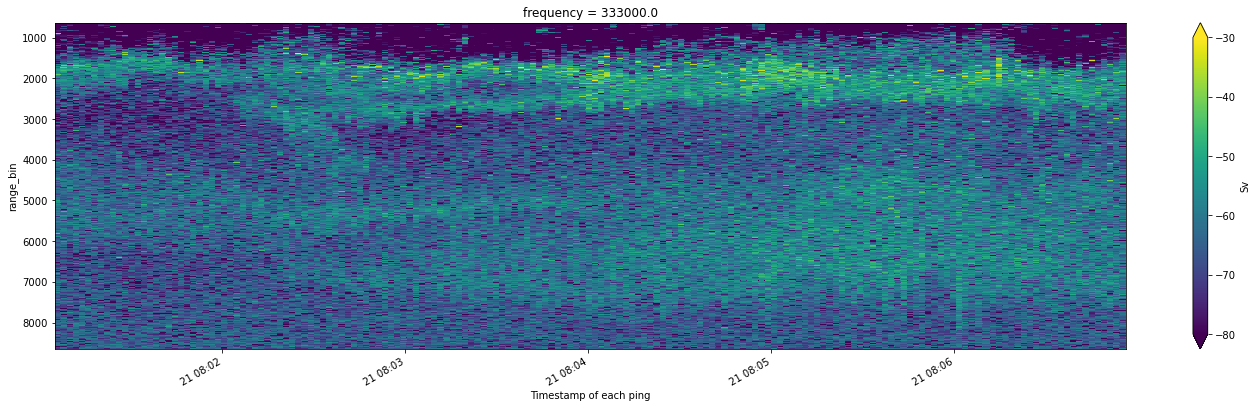

In [56]:
fig = ds.Sv.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

In [57]:
ds_s = ds[['Sv']]
ds_s

<xarray.Dataset>
Dimensions:    (ping_time: 173, range_bin: 8011)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2018-06-21T08:01:06.055000064 ... 2...
    frequency  float64 3.33e+05
  * range_bin  (range_bin) int32 634 635 636 637 638 ... 8641 8642 8643 8644
Data variables:
    Sv         (ping_time, range_bin) float64 -85.67 -84.2 ... -69.41 -59.96

# Parameters
The key parameters here determine the smoothing window in time and depth

In [58]:
time_smoothing = max(len(ds_s['ping_time'].data)//35, 1)
depth_smoothing = len(ds_s['range_bin'].data)//15
print(f'window depth={depth_smoothing}')
print(f'window time={time_smoothing}')
print(f"time min init: {ds_s['ping_time'].min().data}, max: {ds_s['ping_time'].max().data}")
print(f"len time: {len(ds_s['ping_time'])}")

window depth=534
window time=4
time min init: 2018-06-21T08:01:06.055000064, max: 2018-06-21T08:06:55.248999936
len time: 173


## Smooth the backscatter

time min smooth: 2018-06-21T08:01:06.055000064, max: 2018-06-21T08:06:55.248999936
len time smooth: 173


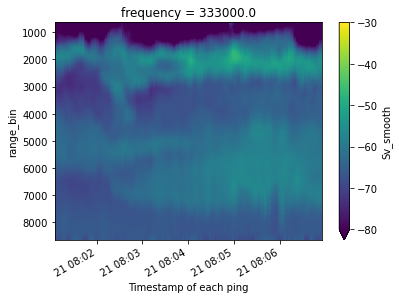

In [59]:
# smoothing on time axis
Sv_smooth = ds_s['Sv'].pad(ping_time=(time_smoothing, time_smoothing), mode='edge').rolling(ping_time=time_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(ping_time=np.arange(time_smoothing, len(ds_s['ping_time'])+time_smoothing))

# smoothing on depth axis
# Sv_smooth = Sv_smooth.pad(range_bin=(depth_smoothing, depth_smoothing), mode='constant', constant_values=-120).rolling(range_bin=depth_smoothing,
#                                                                                                                                    center=True).mean()
Sv_smooth = Sv_smooth.pad(range_bin=(depth_smoothing, depth_smoothing), mode='edge').rolling(range_bin=depth_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(range_bin=np.arange(depth_smoothing, len(ds_s['range_bin'])+depth_smoothing))
ds_s = ds_s.assign(variables={"Sv_smooth": (('ping_time', 'range_bin'), Sv_smooth.data)})

print(f"time min smooth: {Sv_smooth['ping_time'].min().data}, max: {Sv_smooth['ping_time'].max().data}")
print(f"len time smooth: {len(Sv_smooth['ping_time'])}")

ds_s.Sv_smooth.plot(x='ping_time', cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

In [60]:
stacked = ds_s.stack(z=('ping_time', 'range_bin'))
stacked

<xarray.Dataset>
Dimensions:    (z: 1385903)
Coordinates:
    frequency  float64 3.33e+05
  * z          (z) MultiIndex
  - ping_time  (z) datetime64[ns] 2018-06-21T08:01:06.055000064 ... 2018-06-2...
  - range_bin  (z) int64 634 635 636 637 638 639 ... 8640 8641 8642 8643 8644
Data variables:
    Sv         (z) float64 -85.67 -84.2 -82.09 -87.53 ... -69.2 -69.41 -59.96
    Sv_smooth  (z) float64 -86.04 -86.0 -85.96 -85.96 ... -66.36 -66.37 -66.38

# Apply clustering
* KMeans: choose a number of cluster high enought to define the layer of interest as you want. Too low it might contain outside values. Do not hesitate to repeat the process

prep input vector:
2D with depth and Sv

Text(0.5, 1.0, 'Projection on depth/Sv axis, 1 ping_time')

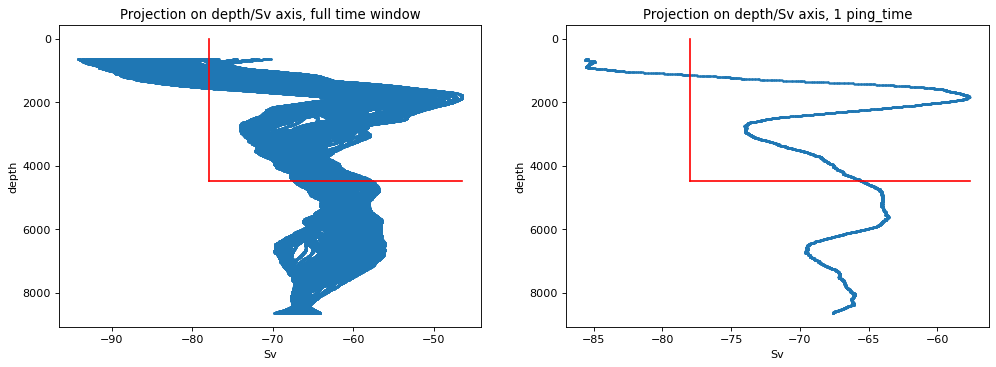

In [61]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), dpi=80)
sc = ax[0].scatter(stacked['Sv_smooth'].data, stacked['range_bin'].data, s=1)
ax[0].set_ylabel('depth')
ax[0].set_xlabel('Sv')
ax[0].plot([-78, stacked['Sv_smooth'].max()], [4500, 4500], color = 'r')
ax[0].plot([-78, -78], [0, 4500], color = 'r')
ax[0].invert_yaxis()
ax[0].set_title('Projection on depth/Sv axis, full time window')

instant = ds_s.isel(ping_time=10)
sc = ax[1].scatter(instant['Sv_smooth'].data, instant['range_bin'].data, s=1)
ax[1].set_ylabel('depth')
ax[1].set_xlabel('Sv')
ax[1].plot([-78, instant['Sv_smooth'].max()], [4500, 4500], color = 'r')
ax[1].plot([-78, -78], [0, 4500], color = 'r')
ax[1].invert_yaxis()
ax[1].set_title('Projection on depth/Sv axis, 1 ping_time')

In [88]:
N_CLUSTERS = 4

X = np.zeros([len(stacked['z']),2])
X[:,0] = stacked['Sv_smooth'].data
X[:,1] = stacked['range_bin'].data

X = StandardScaler().fit_transform(X)

print(f"shape X: {X.shape}")

shape X: (1385903, 2)


In [89]:
%%time
kmeans = KMeans(n_clusters=N_CLUSTERS)
y_kmean = kmeans.fit_predict(X)
stacked = stacked.assign(variables={"clusters_kmean": (('z'), y_kmean)})
stacked

Wall time: 6.14 s


<xarray.Dataset>
Dimensions:         (z: 1385903)
Coordinates:
    frequency       float64 3.33e+05
  * z               (z) MultiIndex
  - ping_time       (z) datetime64[ns] 2018-06-21T08:01:06.055000064 ... 2018...
  - range_bin       (z) int64 634 635 636 637 638 ... 8640 8641 8642 8643 8644
Data variables:
    Sv              (z) float64 -85.67 -84.2 -82.09 ... -69.2 -69.41 -59.96
    Sv_smooth       (z) float64 -86.04 -86.0 -85.96 ... -66.36 -66.37 -66.38
    clusters_kmean  (z) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 3 3 3 3 3 3 3 3

In [90]:
res = stacked.unstack('z')
res

<xarray.Dataset>
Dimensions:         (ping_time: 173, range_bin: 8011)
Coordinates:
    frequency       float64 3.33e+05
  * ping_time       (ping_time) datetime64[ns] 2018-06-21T08:01:06.055000064 ...
  * range_bin       (range_bin) int64 634 635 636 637 ... 8641 8642 8643 8644
Data variables:
    Sv              (ping_time, range_bin) float64 -85.67 -84.2 ... -59.96
    Sv_smooth       (ping_time, range_bin) float64 -86.04 -86.0 ... -66.38
    clusters_kmean  (ping_time, range_bin) int32 1 1 1 1 1 1 1 ... 3 3 3 3 3 3 3

## Plot clustering results

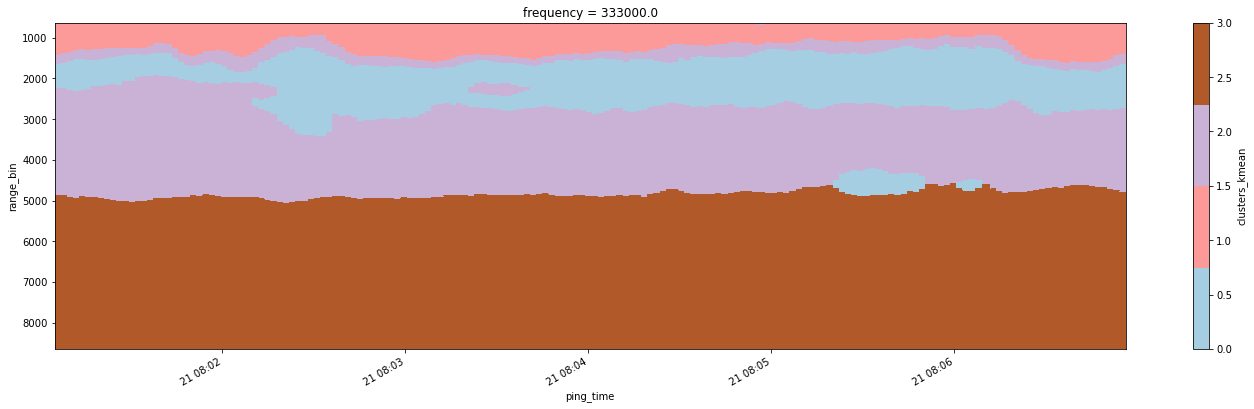

In [91]:
fig = res['clusters_kmean'].plot(x='ping_time', size=6, aspect=4, cmap=plt.cm.get_cmap('Paired', N_CLUSTERS)).figure
plt.gca().invert_yaxis()

In [92]:
# fig.savefig('kmean.png')

Text(0.5, 1.0, 'Projection on depth/Sv axis, 1 ping_time')

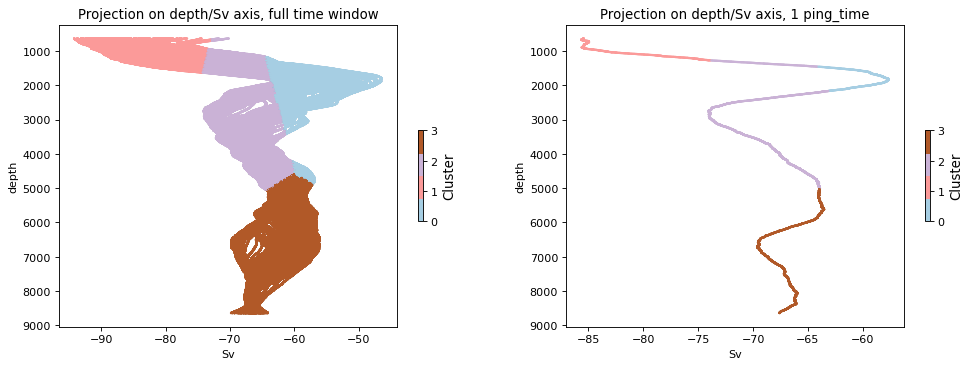

In [93]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), dpi=80)
sc = ax[0].scatter(stacked['Sv_smooth'].data, stacked['range_bin'].data, s=1, c=stacked['clusters_kmean'], cmap=plt.cm.get_cmap('Paired', N_CLUSTERS))
cbar = plt.colorbar(sc, ax=ax[0], shrink=0.3)
cbar.set_label('Cluster', fontsize=12)
ax[0].set_ylabel('depth')
ax[0].set_xlabel('Sv')
# ax[0].plot([-78, instant['Sv_smooth'].max()], [4500, 4500], color = 'r')
# ax[0].plot([-78, -78], [0, 4500], color = 'r')
ax[0].invert_yaxis()
ax[0].set_title('Projection on depth/Sv axis, full time window')

instant = res.isel(ping_time=10)
sc = ax[1].scatter(instant['Sv_smooth'].data, instant['range_bin'].data, s=1, c=instant['clusters_kmean'], cmap=plt.cm.get_cmap('Paired', N_CLUSTERS))
cbar = plt.colorbar(sc, ax=ax[1], shrink=0.3)
cbar.set_label('Cluster', fontsize=12)
ax[1].set_ylabel('depth')
ax[1].set_xlabel('Sv')
# ax[1].plot([-78, instant['Sv_smooth'].max()], [4500, 4500], color = 'r')
# ax[1].plot([-78, -78], [0, 4500], color = 'r')
ax[1].invert_yaxis()
ax[1].set_title('Projection on depth/Sv axis, 1 ping_time')

# Keep the SSL custer
set cluster_id to the number of the cluster you want to extract: possible to keep multiple clusters

define cluster id again to compute the layer depth one by one

In [85]:
cluster_id=2

In [86]:
top_layer = res['range_bin'].where(res['clusters_kmean']==cluster_id).min(dim='range_bin')
bottom_layer = res['range_bin'].where(res['clusters_kmean']==cluster_id).max(dim='range_bin')

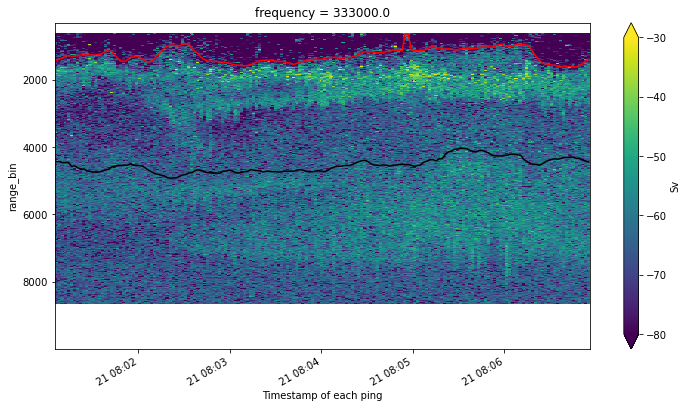

In [87]:
fig, ax = plt.subplots(figsize=(12, 6))
ds_s.Sv.plot(ax=ax,x='ping_time', cmap="viridis", vmin=-80, vmax=-30)
ax.plot(ds.ping_time,top_layer.data, color='red', label='top SSL')
ax.plot(ds.ping_time,bottom_layer.data, color='black', label='bottom SSL')
plt.ylim([300, 9999])
plt.gca().invert_yaxis()
#fig.figure.savefig('kmean_depth_layer.png')

# add the layer info to dataset

In [71]:
ds = ds.assign(variables={"top_scattering_layer": (('ping_time'), top_layer.data)})
ds = ds.assign(variables={"bottom_scattering_layer": (('ping_time'), bottom_layer.data)})
ds

<xarray.Dataset>
Dimensions:                  (ping_time: 173, range_bin: 8011)
Coordinates:
  * ping_time                (ping_time) datetime64[ns] 2018-06-21T08:01:06.0...
    frequency                float64 3.33e+05
  * range_bin                (range_bin) int32 634 635 636 ... 8642 8643 8644
Data variables:
    Sv                       (ping_time, range_bin) float64 -85.67 ... -59.96
    range                    (ping_time, range_bin) float64 3.001 3.007 ... 50.5
    temperature              (ping_time, range_bin) float64 8.0 8.0 ... nan nan
    salinity                 (ping_time, range_bin) float64 35.0 35.0 ... nan
    pressure                 (ping_time, range_bin) float64 5.0 5.0 ... nan nan
    sound_speed              (ping_time, range_bin) float64 1.482e+03 ... nan
    sound_absorption         (ping_time, range_bin) float64 0.08015 ... nan
    sa_correction            (ping_time, range_bin) float64 0.0 0.0 ... 0.0 0.0
    gain_correction          (ping_time, range_bin) float64 24.0 24.0 ... 24.0
    equivalent_beam_angle    (ping_time, range_bin) float64 -21.0 ... -21.0
    top_scattering_layer     (ping_time) float64 4.938e+03 ... 4.928e+03
    bottom_scattering_layer  (ping_time) float64 8.644e+03 ... 8.644e+03